In [18]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, metrics

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [3]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [6]:
# takes about 20 sec
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [8]:
list_tokenized_train[0]

[688,
 75,
 1,
 126,
 130,
 177,
 29,
 672,
 4511,
 12052,
 1116,
 86,
 331,
 51,
 2278,
 11448,
 50,
 6864,
 15,
 60,
 2756,
 148,
 7,
 2937,
 34,
 117,
 1221,
 15190,
 2825,
 4,
 45,
 59,
 244,
 1,
 365,
 31,
 1,
 38,
 27,
 143,
 73,
 3462,
 89,
 3085,
 4583,
 2273,
 985]

In [9]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_te = test_labels[list_classes].values

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

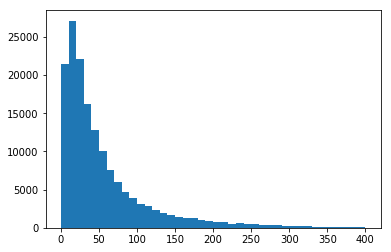

In [11]:
plt.hist(totalNumWords,bins = np.arange(0,410,10)) #[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [23]:
inp = Input(shape=(maxlen, ))

embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 715s 5ms/step - loss: 0.0693 - acc: 0.9775 - val_loss: 0.0497 - val_acc: 0.9816
Epoch 2/2
143613/143613 [==============================] - 720s 5ms/step - loss: 0.0452 - acc: 0.9831 - val_loss: 0.0475 - val_acc: 0.9826


In [26]:
# takes about 2 min
y_pred_keras = model.predict(X_te)

In [27]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_te, y_pred_keras, average='macro', multi_class='ovo')
print(auc_score)

# Why doesn't this work? Pip doesn't upgrade to 0.22? Help ...

TypeError: roc_auc_score() got an unexpected keyword argument 'multi_class'

In [28]:
import sklearn
print(y_pred_keras.shape)
print(y_te.shape)
print('The scikit-learn version is {}.'.format(sklearn.__version__))

(153164, 6)
(153164, 6)
The scikit-learn version is 0.20.
